In [1]:
#@formatter:off
%load_ext autoreload
%autoreload 2
#@formatter:on

In [2]:
from typing import List, Tuple, Optional, Iterable

import matplotlib.pyplot as plt
import numpy as np

from module.builders import TranslationPathsBuilder, AtomsBuilder
from module.helpers import CellHelper, AtomsBuilderHelper
from module.models import (TranslateOperation, UnitConstraint, UnitConstraintsList, Atom, PositionDefinition,
                           AtomDefinition)

# Определения

## Определение ограничений и трансформаций

In [3]:
constraints_list = UnitConstraintsList([
    UnitConstraint(0, 1, 1, 0.0),
    UnitConstraint(0, 1, -1, 0.0),
    UnitConstraint(1, -1, 0, 0.0),
    UnitConstraint(-1, -1, 0, -0.5),
    UnitConstraint(0, -1, 0, -0.125),
])
translations = [
    TranslateOperation('xZY'),
    TranslateOperation('xzy'),
    TranslateOperation('yxz'),
    TranslateOperation('YXz', np.array([1, 1, 0]) / 2),
    TranslateOperation('ZYX', np.array([1, 1, 1]) / 4),
]

## Определение позиций

In [4]:
# b_pos = PositionDefinition('b', np.array([0.5, 0.5, 0.5]))
# c_pos = PositionDefinition('c', np.array([0.125, 0.125, 0.125]))
# e_pos = PositionDefinition('e', np.array([0., 0., 0.]), [np.array([1, 1, 1])])
b_pos = PositionDefinition('b', np.array([0.5, 0., 0.]))
c_pos = PositionDefinition('c', np.array([0.125, 0.125, 0.125]))
e_pos = PositionDefinition('e', np.array([0., 0., 0.]), [np.array([1, 1, 1])])

In [5]:
def get_e_position_paths() -> List[Tuple[TranslateOperation]]:
    shifted_point = e_pos.base_point + 0.01 * e_pos.freedom_vectors[0]
    builder = TranslationPathsBuilder(translations)
    builder.build_from(shifted_point)
    return builder.get_paths()


positions_paths = {
    e_pos: get_e_position_paths()
}

## Определение атомов

In [6]:
# FeV2O4
# Координационное число = 6
# https://dpva.ru/Guide/GuidePhysics/Length/IonicRadius/
# Fe   +2
# V    +3
# O    -2
# Из книги (с. 65)
# Fe   +2   75(г)/92(в) пм
# V    +3   78 пм
# O    -2   126 пм
# 1 А = 100 пм
ferrum_definition = AtomDefinition('Fe', 0.75, b_pos)
vanadium_definition = AtomDefinition('V', 0.78, c_pos)
oxygenium_definition = AtomDefinition('O', 1.26, e_pos)
atoms_definitions = [
    ferrum_definition,
    vanadium_definition,
    oxygenium_definition,
]
constant_atoms_definitions = [
    ferrum_definition,
    vanadium_definition
]

## Создание атомов

In [7]:
builder = AtomsBuilder(translations)
atoms = builder.build_atoms(atoms_definitions, {e_pos: [0.01]})
constant_atoms = builder.build_atoms(constant_atoms_definitions)
len(atoms), len(constant_atoms)

(56, 24)

# Вычисление некоторых параметров перед основными вычислениями (в полуручном формате)

## Определение  диапазона размера ячейки для размещения константных атомов без пересечений

In [8]:
def check_intersection(atoms: List[Atom], lattice_size):
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            distance = lattice_size * CellHelper.calc_periodic_distance(atoms[i].point, atoms[j].point)
            radii_sum = atoms[i].atom_definition.radius + atoms[j].atom_definition.radius
            if distance < radii_sum:
                return True
    return False

check_intersection(constant_atoms, 4), check_intersection(constant_atoms, 5)

(True, False)

## Точное определение нижнего значения размера ячейки (наиболее плотная упаковка постоянных атомов)

In [9]:
def calc_compressed_lattice_size(atoms: List[Atom], left, right):
    while abs(right - left) > 1e-8:
        center = (left + right) / 2
        if check_intersection(atoms, center):
            left = center
        else:
            right = center
    return (left + right) / 2


min_lattice_size = calc_compressed_lattice_size(constant_atoms, 4, 5)
min_lattice_size

4.412346314638853

# Основной блок

## Вычисление размера ячейки и параметра сдвига "плавающего" атома

In [10]:
class CompressionSearcher:
    def __init__(self,
                 min_lattice_size, max_lattice_size,
                 min_u, max_u):
        self._error = 1e-8
        self._min_lattice_size = min_lattice_size
        self._max_lattice_size = max_lattice_size
        self._min_u = min_u
        self._max_u = max_u

    def find_compression(self) -> Optional[Tuple[float, float]]:
        '''
        :return: (lattice_size, u) or None
        '''
        left, right = self._min_lattice_size, self._max_lattice_size
        last_valid_result = None
        while abs(right - left) > self._error:
            lattice_size = (right + left) / 2
            # тот самый параметр "плавающего" атома
            u = self._find_u_without_penalty(lattice_size)

            if u is not None:
                last_valid_result = (lattice_size, u)
                right = lattice_size
            else:
                left = lattice_size

        return last_valid_result

    def _find_u_without_penalty(self, lattice_size) -> Optional[float]:
        u = self._min_u
        while u <= self._max_u:
            floating_atoms = CompressionSearcher._build_floating_atoms(u)

            floating_penalty = CompressionSearcher._calc_penalty_in_one_collection(
                floating_atoms, lattice_size)
            constant_penalty = CompressionSearcher._calc_penalty_in_two_collections(
                constant_atoms,floating_atoms, lattice_size)

            max_penalty = max(constant_penalty, floating_penalty / 2)

            if max_penalty == 0:
                return u

            u += max_penalty / lattice_size
        return None

    @staticmethod
    def _build_floating_atoms(u) -> List[Atom]:
        return AtomsBuilderHelper.build_atoms_by_paths(
            oxygenium_definition,
            positions_paths[oxygenium_definition.position_definition],
            {oxygenium_definition.position_definition: [u]}
        )

    @staticmethod
    def _calc_penalty_in_one_collection(atoms: List[Atom], lattice_size) -> float:
        max_penalty = 0
        for i in range(len(atoms)):
            for j in range(i + 1, len(atoms)):
                distance = lattice_size * CellHelper.calc_periodic_distance(atoms[i].point, atoms[j].point)
                radii_sum = atoms[i].atom_definition.radius + atoms[j].atom_definition.radius
                max_penalty = max(max_penalty, radii_sum - distance)
        return max_penalty

    @staticmethod
    def _calc_penalty_in_two_collections(first: Iterable[Atom], second: Iterable[Atom], lattice_size: float) -> float:
        max_penalty = 0
        for first_atom in first:
            for second_atom in second:
                distance = lattice_size * CellHelper.calc_periodic_distance(first_atom.point, second_atom.point)
                radii_sum = first_atom.atom_definition.radius + second_atom.atom_definition.radius
                max_penalty = max(max_penalty, radii_sum - distance)
        return max_penalty

In [11]:
compression_searcher = CompressionSearcher(min_lattice_size, 20, 0, 1)
lattice_size, u = compression_searcher.find_compression()
print(f'{lattice_size=}, {u=}')

lattice_size=8.522754940198901, u=0.3638381544609976


## Создание .vesta файла для отображения результата

In [12]:
# Поля, определенные внутри шаблона
# title
# lattice_size
# u
def export_to_vesta():
    with open('template.vesta', 'r') as file:
        template = file.read()
    result = template.format(title='some title',
                             lattice_size=lattice_size,
                             u=u)
    with open('result.vesta', 'w') as file:
        file.write(result)


export_to_vesta()

# Вспомогательный блок

## Определение истинных позиций неприводимой ячейки

In [13]:
true_base_atoms = list(
    filter(
        lambda a: constraints_list.check_including_bounds(a.point),
        atoms
    )
)
true_base_atoms

[Atom(Fe, b, [0.5 0.  0. ]),
 Atom(V, c, [0.125 0.125 0.125]),
 Atom(O, e, [0.01 0.01 0.01])]

### ??? Почему-то при параметре 0.35 ни одного атома кислорода не попало в неприводимую ячейку

In [14]:
tm_builder = AtomsBuilder(translations)
tm_atoms = tm_builder.build_atoms(atoms_definitions, {
    oxygenium_definition.position_definition: [0.3563425503447093]
})
true_base_atoms = list(
    filter(
        lambda a: constraints_list.check_including_bounds(a.point),
        tm_atoms
    )
)
true_base_atoms
# (8.761291446936681, 0.3563425503447093)

[Atom(Fe, b, [0.5 0.  0. ]), Atom(V, c, [0.125 0.125 0.125])]

## ~~Определение максимального значения свободного параметра позиции "e"~~
## Некорректно, т.к. что-то непонятное с неприводимой ячейкой (см. выше)

In [15]:
def calc_freedom_coefficient_constraint(left, right):
    while abs(right - left) > 1e-12:
        c = (left + right) / 2
        fv = e_pos.freedom_vectors[0]
        p = e_pos.base_point + c * fv
        if constraints_list.check_including_bounds(p):
            left = c
        else:
            right = c
    return left


calc_freedom_coefficient_constraint(0, 1)

0.125

## Отображение неприводимой ячейки

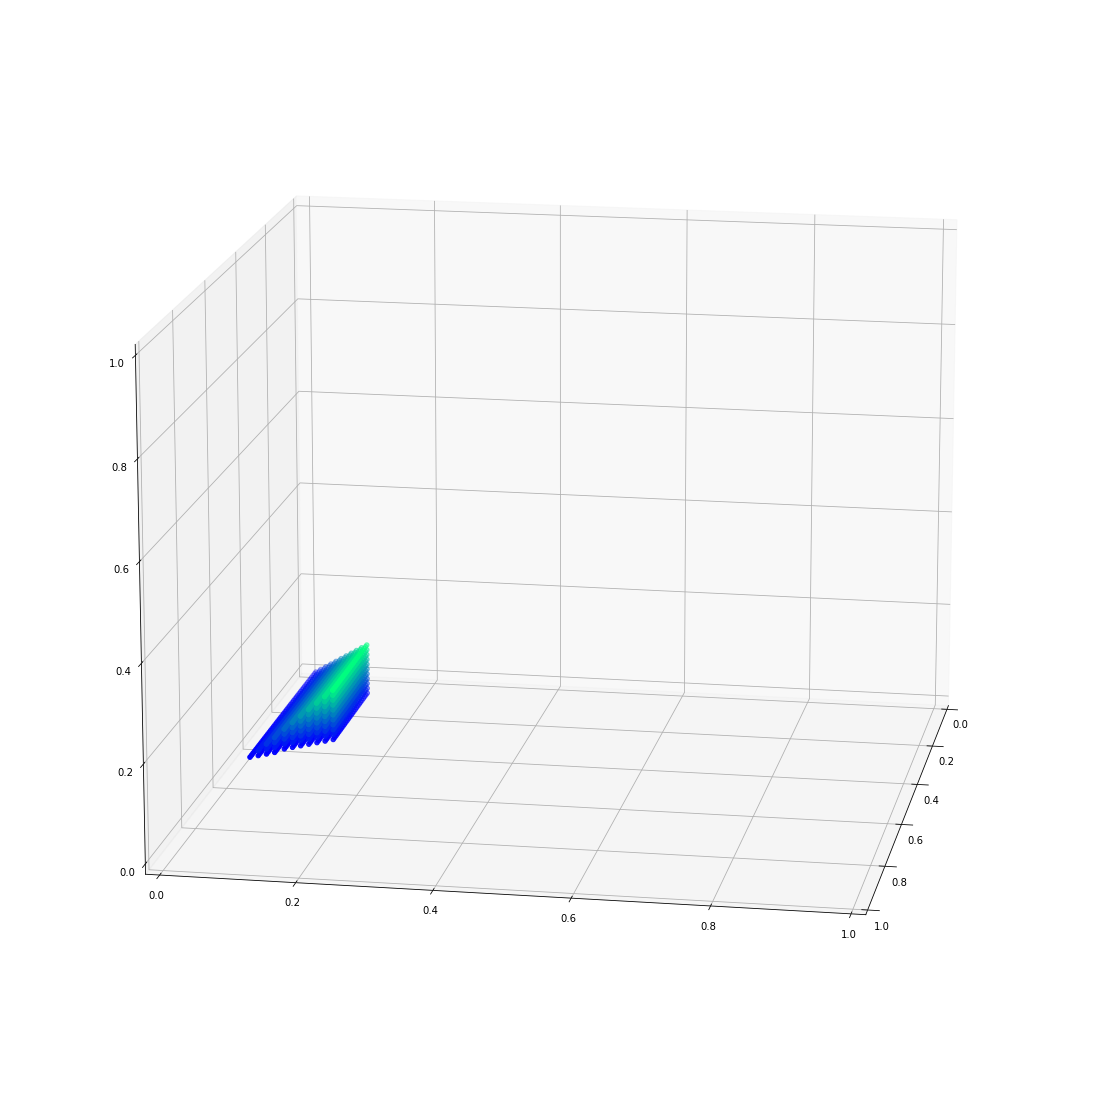

In [16]:
# %%script false --no-raise-error

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
xs, ys, zs = [], [], []
for x in np.linspace(0, 0.6, 60):
    for y in np.linspace(0, 0.2, 20):
        for z in np.linspace(0, 0.2, 20):
            if constraints_list.check([x, y, z]):
                xs.append(x)
                ys.append(y)
                zs.append(z)
ax.scatter(xs, ys, zs, c=zs, cmap='winter')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.view_init(elev=15, azim=10)